In [5]:
import localcider
from localcider.sequenceParameters import SequenceParameters
from Bio import SeqIO
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import ks_2samp
import pandas as pd
import itertools
from sklearn.manifold import TSNE
import seaborn as sns
import re
import scipy.special as sps
from scipy.stats import ttest_ind

In [6]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
# rc('text', usetex=True)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.rcParams['font.size']=15
plt.rcParams['pdf.fonttype']=42
plt.rcParams["text.usetex"]=False

## Stitching together IDRs from the different proteins and getting a list of IDRs with their Uniprot ID, strating position, and ending position

In [4]:
class IDR:
    """Class for keeping track of starting and ending positions of an IDR"""
    
    def __init__(self, start, end):
        self.start = start
        self.end = end
        
    def check_and_extend(self, idr_obj):
        # Check if the self sequence is a subset of the supplied idr
        if idr_obj.start <= self.start and idr_obj.end >= self.end:
            # If yes, change the start and end of the self sequence to the start and end of the supplied idr
            self.start = idr_obj.start
            self.end = idr_obj.end
            return True
        # Check if the end of the supplied sequence lies between the start and end of the self sequence
        elif idr_obj.end > self.start  and idr_obj.end <= self.end:
            # If yes, then there is overlap. Update the start of self sequence appropriately
            self.start = np.min([idr_obj.start, self.start])
            return True
        # Check if the start of the supplied sequence lies between the start and end of the self sequence
        elif idr_obj.start >= self.start and idr_obj.start < self.end:
            # If yes, then there is overlap. Update the end of self sequence appropriately
            self.end = np.max([idr_obj.end, self.end])
            return True
        # This is a completely new IDR
        else:
            return False
        
    def check_and_exclude(self, pfam_start, pfam_end):
        # Check if the self sequence is a subset of the supplied pfam domain
        if pfam_start <= self.start and pfam_end >= self.end:
            # If yes, remove this domain
            return (True, True, None)
        # Check if the the pfam domain is contained within the self sequence
        elif pfam_start > self.start and pfam_end < self.end:
            # If yes, then there is overlap. Update the start of self sequence appropriately
            new_idr = IDR(start=pfam_end, end=self.end)
            self.end = pfam_start
            return (False, True, new_idr)
        # Check if the start of the pfam domain lies between the start and end of the self sequence
        elif pfam_start >= self.start and pfam_start <= self.end:
            # If yes, then there is overlap. Update the end of self sequence appropriately
            self.end = pfam_start
            return (False, True, None)
        # Check if the end of the pfam domain lies between the start and end of the self sequence
        elif pfam_end >= self.start and pfam_end <= self.end:
            self.start = pfam_end
            return (False, True, None)
        # No overlap of the pfam domain with the idr whatsoever
        else:
            return (False, True, None)

In [7]:
def get_disordered_sequences(filename):
    """Function to read a file that is the output of InterProScan, construct a list of disordered domains predicted 
    by MobiDBLite by stitching together all predictions, and excluding regions that overlap with pfam domains """
    
    df = pd.read_csv(filename, delimiter='\t', 
                     names=['id', 'analysis', 'start', 'end'] , 
                     header=None, usecols=[0, 3, 6, 7])
    
    idr_dict = {}
    
    for protein in df['id'].unique():
        
        # Step 1: Get the start and end positions of the unique IDRs by stitching together sequences
        # ------------------------------------------------------------------------------------------
        
        # Select the row indices in the file that correspond to predictions of disordered sequences
        selected_idr_row_indices = df.index[(df['id']==protein)*(df['analysis']=='MobiDBLite')]
        
        # Check if this protein has at least one disorder prediction
        if len(selected_idr_row_indices) > 0: 
            
            idr_start_end_list = []
            # Initialize a list that will store the IDR class objects containing
            # start and end positions of IDRs of this protein
            
            # Store the raw list of idr start and end positions
            for index in selected_idr_row_indices:
                current_idr_obj = IDR(start=df.iloc[index]['start'], end=df.iloc[index]['end'])
                idr_start_end_list.append(current_idr_obj)
            
            # Stich together all the IDRs in the idr_start_end_list
            stitching_flag = True
            while stitching_flag:
                # Nothing to stitch if there is only one idr
                if len(idr_start_end_list) == 1:
                    break
                # If there are many idrs, compare every pair in the idr_start_end_list and check for overlap or subset
                for idr1, idr2 in itertools.combinations(idr_start_end_list, r=2):
                    stitching_flag = idr1.check_and_extend(idr2)
                    # If there is overlap or subset, remove the current idr_object[j], then restart the loops again
                    if stitching_flag:
                        idr_start_end_list.remove(idr2)
                        break 
            
            # Step 2: Exclude the idrs that overlap with pfam domains
            # -------------------------------------------------------
            
            # Select row indices that corresponds to pfam domain predictions
            selected_pfam_row_indices = df.index[(df['id']==protein)*(df['analysis']!='MobiDBLite')]
            
            # Exclude the idrs that overlap with pfam domains
            if len(selected_pfam_row_indices) > 0:             
                for index in selected_pfam_row_indices:
                    for idr in idr_start_end_list:
                        is_exclude, is_overlap, new_idr = idr.check_and_exclude(pfam_start=df.iloc[index]['start'],
                                                                                pfam_end=df.iloc[index]['end'])
                        if is_exclude:
                            # print("IDR removed because it is contained in a Pfam domain:", str(protein), 
                            #       '[', str(idr.start), '-', str(idr.end), ']')
                            idr_start_end_list.remove(idr)
                            break
                        else:
                            if new_idr is not None:
                                idr_start_end_list.append(new_idr)
                                # print("IDR broken into two because of overlap with Pfam domain:", 
                                #       str(protein), '[', str(idr.start), '-', str(idr.end), ']',
                                #       '[', str(new_idr.start), '-', str(new_idr.end), ']')
                            if is_overlap:
                                break
                            
            # print('IDR list after stitching and excluding:')
            # print(str(protein))
            # print([str(idr.start) + '-' + str(idr.end) for idr in idr_start_end_list])
            
            # Step 3: Exclude IDRs that are smaller than 30 amino acids long
            idr_dict[protein] = []
            # The final list of start-end positions of IDRs
            for idr in idr_start_end_list:
                if idr.end - idr.start < 40:
                    continue
                    # print("IDR removed because of small size:", str(protein), 
                    #      '[', str(idr.start), '-', str(idr.end), ']')
                else:
                    idr_dict[protein].append(idr) 
            # print('------------------------------------------')
    
    return idr_dict

In [8]:
def analyze_files(fasta_file_list, iprscan_file_list, names, colors, figname):
    """Function to analyze the charge distributions of sequences present in a list of files and display statistics"""
    
    assert len(fasta_file_list) == len(iprscan_file_list) and len(iprscan_file_list) == len(names), \
    "The lists need to be the same size"
    
    charge_features_dict_list = []
    
    for i in range(len(fasta_file_list)): 
        
        # Get the list of stitched and filtered idr start and end positions from the iprscan file
        idr_dict = get_disordered_sequences(iprscan_file_list[i])
        
        # Get the list of protein sequences from the fasta file
        protein_sequences = SeqIO.parse(fasta_file_list[i], 'fasta')
        
        charge_features_dict = {'ID': [], 'start_end': [], 'net_charge_per_residue': [], 
                                'fraction_positive': [], 'fraction_negative': []}
        
        for sequence in protein_sequences:
            if sequence.id in idr_dict.keys():
                for idr in idr_dict[sequence.id]:
                    # Extract the IDR sequence by crossreferencing start and end positions in idr_dict with the 
                    # sequences in protein_sequences
                    if str(sequence.seq[idr.start:idr.end]) != "":
                        # print("--", str(sequence.seq[idr.start:idr.end]), "--")
                        obj = SequenceParameters(str(sequence.seq[idr.start:idr.end]))
                        # Net charge per residue of the sequence
                        charge_features_dict['net_charge_per_residue'].append(obj.get_NCPR(pH=7.2)) 
                        # Using a typical pH value of 7.2 of the nucleus, and assuming that this corresponds 
                        # to the nucleolus
                        # Fraction of positive charges
                        charge_features_dict['fraction_positive'].append(obj.get_fraction_positive())
                        # Fraction of negative charges
                        charge_features_dict['fraction_negative'].append(obj.get_fraction_negative())
                        # Sequence ID 
                        charge_features_dict['ID'].append(str(sequence.id))
                        # Start and end positions
                        charge_features_dict['start_end'].append((idr.start, idr.end))                  
                    
        # Store this list of charge features
        charge_features_dict_list.append(charge_features_dict)
        
        # Print the number of IDR sequences obtained
        print('Number of IDRs from ' + str(iprscan_file_list[i]) + ' : ', len(charge_features_dict['ID']))
    
    # Exclude the IDRs from the second list of files that overlap with the first list of files. 
    # We are assuming here that the second list of IDRs contains some overlap with the first. 
    charge_features_dict_dropped = {'ID': [], 'start_end': [], 'net_charge_per_residue': [], 
                                    'fraction_positive': [], 'fraction_negative': []}
    for i in range(len(charge_features_dict_list[1]['ID'])):
        if charge_features_dict_list[1]['ID'][i] not in charge_features_dict_list[0]['ID']:
            for key in charge_features_dict_list[1].keys():
                charge_features_dict_dropped[key].append(charge_features_dict_list[1][key][i])
    
    charge_features_dict_list[1] = charge_features_dict_dropped
    
    # Plot distributions of the charge sequence parameters of these proteins
    fig, axs = plt.subplots(3, 2, figsize=(6, 9))
    keys = ['net_charge_per_residue', 'fraction_positive', 'fraction_negative']
    ranges = [(-0.6, 0.6), (0.0, 0.6), (0.0, 0.6)]
    titles = ['Net charge per residue', 'Fraction positive', 
            'Fraction negative']
    for i in range(len(names)):
        # Plot the distributions of the charge features
        for j in range(len(keys)): 
            sns.kdeplot(data=charge_features_dict_list[i][keys[j]], fill=True, cumulative=True,
                        ax=axs[j,0], label=names[i], color=colors[i]).set(xlim=ranges[j])
            sns.kdeplot(data=charge_features_dict_list[i][keys[j]], fill=True, ax=axs[j,1], 
                        label=names[i], bw_adjust=1.0, color=colors[i]).set(xlim=ranges[j])
            print('Average ', titles[j], 'in', names[i], ':', np.mean(charge_features_dict_list[i][keys[j]]))
    for i in range(len(keys)):
        axs[i,0].legend()
        axs[i,0].set_xlabel(titles[i])
        axs[i,0].set_ylabel('Cumulative density')
        # axs[i,1].legend()
        axs[i,1].set_xlabel(titles[i])
        axs[i,1].set_ylabel('Probability density')
    fig.tight_layout()
    plt.savefig('Figures_for_paper/Charge_distribution_' + figname + '.svg', format='svg', dpi=600)
    plt.savefig('Figures_for_paper/Charge_distribution_' + figname + '.pdf', format='pdf', dpi=600)
    plt.show()
    plt.close()
    
    return charge_features_dict_list

In [9]:
def analyze_structured_domains(fasta_file_list, iprscan_file_list, figname, 
                               names=['FC', 'Rest'], go_file_name='go.obo'):
    """Function to analyze the structured domains of the proteins"""
    
    df_list = []

    # Read sequence ID and the corresponding GO terms from the tsv file
    
    for file in iprscan_file_list:
        df = pd.read_csv(file, delimiter='\t', names=['id', 'GO_terms'], header=None, usecols=[0, 13])
        # Drop those row entries where there are no GO annotations
        df = df[df['GO_terms'] != '-']
        # Remove all proteins that occurred in the previous datasets
        for df_previous in df_list:
            for protein in df['id'].unique():
                if protein in df_previous['id']:
                    drop_indices = df[df['id']==protein].index
                    df.drop(drop_indices, inplace=True)
        df_list.append(df)

    # Get a histogram of the number of times a particular GO ID occurs in the dataset
    
    # Step 1: Get the unique GO terms
    unique_GO_terms_list = []
    for df in df_list:
        unique_GO_terms_list += [go for string in df['GO_terms'] for go in string.split('|')]
    unique_GO_terms_list = [go_term.split('(')[0] for go_term in unique_GO_terms_list]
    unique_GO_terms = set(unique_GO_terms_list)        
    go_names_list = []
    go_id_list_sorted = []
    go_namespace_list = []
    
    # Step 2: Read through the GO OBO file and assign names to the GO terms
    store_next_line = 0
    with open(go_file_name, 'r') as f:
        pattern = re.compile('^id: GO:.*')
        for line in f:
            if store_next_line == 1:
                # Read the name of the GO term
                go_names_list.append(line.rstrip()[6:])
                store_next_line = 2
            elif store_next_line == 2:
                # Read the namespace of the GO term i.e. molecular_function, biological_process, cellular_component
                go_namespace_list.append(line.rstrip()[11:])
                store_next_line = 0
            if pattern.match(line.rstrip()) and line.rstrip()[4:] in unique_GO_terms:
                go_id_list_sorted.append(line.rstrip()[4:])
                # The next line contains the name of the GO term
                store_next_line = 1
    
    # Step 3: Count the number of occurences of each GO term in each dataset (i.e. FC and rest)         
    go_names_df = pd.DataFrame(data=np.array([go_id_list_sorted, go_names_list, go_namespace_list]).transpose(), 
                               columns=['go_id', 'go_name', 'go_namespace'])
    # print(go_names_df.head(20))
    # Drop those GO terms which are not in the namespace of molecular_functions
    drop_indices = go_names_df[go_names_df['go_namespace']!='molecular_function'].index
    go_names_df.drop(drop_indices, inplace=True)
    
    for i in range(len(df_list)):
        # Count the number of occurences of each GO term in each dataset
        go_names_df[names[i]] = np.zeros(len(go_names_df.go_name))
        for protein in df_list[i]['id'].unique():
            go_terms_for_this_protein = [go for string in list(df_list[i][df_list[i]['id']==protein]['GO_terms']) 
                                         for go in string.split('|')]
            go_terms_for_this_protein = [go.split('(')[0] for go in go_terms_for_this_protein]
            for go_term in go_names_df.go_id:
                if go_term in go_terms_for_this_protein:
                    go_names_df[names[i]][go_names_df['go_id']==go_term] += 1.0
        
        # Remove uninformative GO terms like nucleus and protein binding that are 
        # go_names_df[names[i]][go_names_df['go_name'] == 'nucleus'] = 0
        # go_names_df[names[i]][go_names_df['go_name'] == 'protein binding'] = 0
        go_names_df = go_names_df.sort_values(by=names[i], ascending=False)
        
        # Show the top few GO terms in each file
        plt.bar(go_names_df['go_name'].iloc[0:10], go_names_df[names[i]].iloc[0:10])
        plt.xticks(rotation=90)
        plt.show()
        plt.close()
        
    # Drop those GO terms in the dataset that have very small counts
    # Ignore the GO terms that occur less than 5 times:
    drop_indices = go_names_df[go_names_df['FC'] + go_names_df['Rest'] <= 10.0].index
    go_names_df.drop(drop_indices, inplace=True)
    
    # Perform Fisher exact test to figure out which GO labels are significantly enriched or depleted
    
    num_sequences = [0.0, 0.0]
    for i in range(len(fasta_file_list)):
        protein_sequences = SeqIO.parse(fasta_file_list[i], 'fasta')
        counter = 0
        for sequence in protein_sequences:
            counter += 1
        num_sequences[i] = counter
    num_fc = num_sequences[0]
    num_rest = num_sequences[1]
    
    # num_fc = len(df_list[0]['id'].unique())
    # num_rest = len(df_list[1]['id'].unique())
    
    def get_p_value(fc_counts, rest_counts, num_fc_proteins=num_fc, num_rest_proteins=num_rest):
        return (sps.comb(fc_counts + rest_counts, fc_counts)*
                sps.comb(num_fc_proteins - fc_counts + num_rest_proteins - rest_counts, num_fc_proteins - fc_counts)/
                sps.comb(num_fc_proteins + num_rest_proteins, num_fc_proteins))

    go_names_df['pvalue'] = go_names_df.apply(lambda x: get_p_value(x.FC, x.Rest), axis=1)

    # Calculate enrichment values and plot
    
    go_names_df['fraction_FC'] = go_names_df['FC']/num_fc
    go_names_df['fraction_Rest'] = go_names_df['Rest']/num_rest
    go_names_df['enrichment'] = np.divide(go_names_df['fraction_Rest'], go_names_df['fraction_FC'])
    go_names_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    go_names_df.dropna(subset=["enrichment"], how="all", inplace=True)
    
    # Show scatter plot of significantly different GO terms
    
    go_names_df = go_names_df.sort_values(by='pvalue', ascending=True)
    print(go_names_df.head(20))
    
    f1 = np.divide(go_names_df['Rest'], num_rest)
    f2 = np.divide(go_names_df['FC'], num_fc)
    max_fraction = np.max([f1, f2])
    plt.scatter(f1, f2, c='darkgrey')
    
    x = np.linspace(0.0, max_fraction*1.1, 100)
    y = np.linspace(0.0, max_fraction*1.1, 100)
    xv, yv = np.meshgrid(x, y)
    plt.plot(x, y, '--k')
    p_grid = np.array([get_p_value(xv[i]*num_fc, yv[i]*num_rest) for i in range(len(xv))])
    # p_grid[p_grid > 0.1] = 1.0 
    # p_grid[(p_grid <= 0.1)*(p_grid > 0.0)] = 0.0 
    # print(p_grid)
    plt.contourf(xv, yv, p_grid.transpose(), levels=[0.05, 1.0, ], alpha=0.1)
    
    significant_indices = go_names_df[go_names_df['pvalue'] < 0.05].index
    for (x, y, name) in zip(np.divide(go_names_df['Rest'][significant_indices], num_rest),
                            np.divide(go_names_df['FC'][significant_indices], num_fc),
                            go_names_df['go_name'][significant_indices]):
        plt.text(x, y, name, fontsize=8)
    
    plt.xlim([0.0, max_fraction*1.1])
    plt.ylim([0.0, max_fraction*1.1])
    plt.xlabel('Fraction in rest of nucleolus')
    plt.ylabel('Fraction in FC')
    plt.savefig('Figures_for_paper/Significant_functions' + figname + '.svg', format='svg', dpi=600)
    plt.savefig('Figures_for_paper/Significant_functions' + figname + '.pdf', format='pdf', dpi=600)
    plt.show()
    plt.close()
    
    # Plot the functions that are most significantly enriched in rest of the nucleolus
    go_names_df = go_names_df[go_names_df['pvalue'] < 0.05]
    
    fig, axs = plt.subplots(1, 1, figsize=(3,5))
    go_names_df = go_names_df.sort_values(by='enrichment', ascending=False)
    axs.bar(go_names_df['go_name'].iloc[0:4], go_names_df['enrichment'].iloc[0:4])
    plt.axhline(y=1.0, color='k', linestyle='--')
    plt.xticks(rotation=90)
    axs.set_ylabel('Fold enrichment in rest of nucleolus')
    plt.savefig('Figures_for_paper/Enrichment_rest_' + figname + '.svg', format='svg', dpi=600)
    plt.savefig('Figures_for_paper/Enrichment_rest_' + figname + '.pdf', format='pdf', dpi=600)
    plt.show()
    plt.close()
    
    fig, axs = plt.subplots(1, 1, figsize=(3,5))
    go_names_df = go_names_df.sort_values(by='enrichment', ascending=True)
    axs.bar(go_names_df['go_name'].iloc[0:4], np.divide(1.0, go_names_df['enrichment'].iloc[0:4]))
    plt.axhline(y=1.0, color='k', linestyle='--')
    plt.xticks(rotation=90)
    axs.set_ylabel('Fold enrichment in FC')
    plt.savefig('Figures_for_paper/Enrichment_FC_' + figname + '.svg', format='svg', dpi=600)
    plt.savefig('Figures_for_paper/Enrichment_FC_' + figname + '.pdf', format='pdf', dpi=600)
    plt.show()
    plt.close()

In [42]:
# Function to make violin plots

def make_violin_plots(dataset, labels, colors, ylabel, figname):
    """The input dataset should be a list of lists or an array of array,
    with the first index being the condition and the second index being 
    the index of the datapoint in that condition """
    
    # Plot violin plot of the data
    fig, axs = plt.subplots(1, 1, figsize=(2,4))

    # Segment the dataset by condition
    data = [dataset[i] for i in range(len(dataset))]

    # Plot violinplot
    parts = axs.violinplot(data, vert=True, widths=0.8, showmeans=True, showextrema=False)

    parts['cmeans'].set_color(['k']*len(data))
    for pc in parts['bodies']:
        pc.set_facecolor('white')
        pc.set_edgecolor('black')
        pc.set_alpha(1.0)
        pc.set_linewidth(2.0)
        
    # Set the x labels for the plot
    def set_axis_style(ax, labels):
        ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
        ax.set_xlim(0.25, len(labels) + 0.75)
        
    set_axis_style(axs, labels)

    # Plot the scatter plot of data
    for i in range(len(data)):
        # Add some random "jitter" to the x-axis
        x = np.random.normal(i+1, 0.1, size=len(data[i]))
        axs.scatter(x, data[i], color=colors[i], marker='o', alpha=1.0, s=3.0)

    axs.set_ylabel(ylabel)
    # axs.set_ylim(np.min(data), np.max(data))

    plt.savefig(figname + '.svg', format='svg', dpi=600)
    plt.savefig(figname + '.pdf', format='pdf', dpi=600)
    
    plt.show()
    plt.close()

    for i in range(len(data)):
        for j in range(i+1, len(data)):
            print('Welch t-test for data ' + str(i) + ' and data ' + str(j) + ': ', 
                  ttest_ind(data[i], data[j], equal_var=False))

# Gene Ontology annotations

The GO IDs corresponding the different components of the nucleolus are:
1. **Nucleolar FC:** GO:0001650
2. **Nucleolar DFC:** GO:0001651
3. **Nucleolar GC:** GO:0001652
4. **Nucleolus**: GO:0005730

We searched for all the proteins that corresponded to each of the above GO IDs in from Uniprot. We only selected those sequences that have manual GO assertions as shown below:

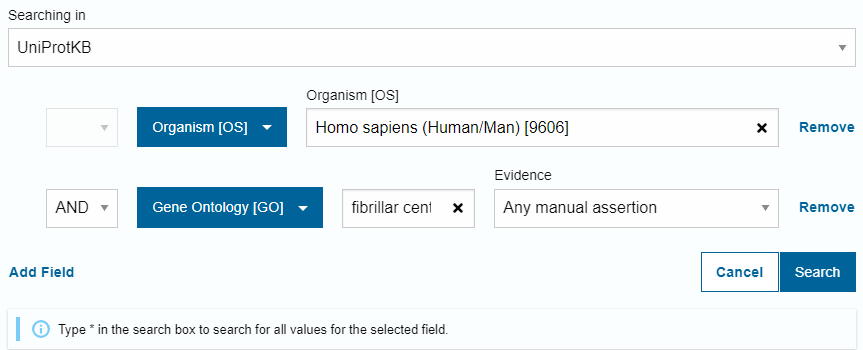

We also selected only those sequences that have been reviewed, present in SwissProt:

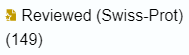

For these sequences, we passed them through iprscan5 to get the Pfam, CDD, and Prosite domains and regions of disorder as predicted by MobiDBLite.

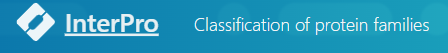

# Humans: FC vs rest of nucleolus

## Analysis of IDRs

Number of IDRs from Human_Protein_Atlas/HPA_human_FC.tsv :  274
Number of IDRs from Human_Protein_Atlas/HPA_human_nonFC.tsv :  730
Average  Net charge per residue in FC : -0.031127698546378355
Average  Fraction positive in FC : 0.11662745454464574
Average  Fraction negative in FC : 0.15120343342040146
Average  Net charge per residue in Rest : 0.0006611807395233967
Average  Fraction positive in Rest : 0.1479289794053484
Average  Fraction negative in Rest : 0.1503296895689808


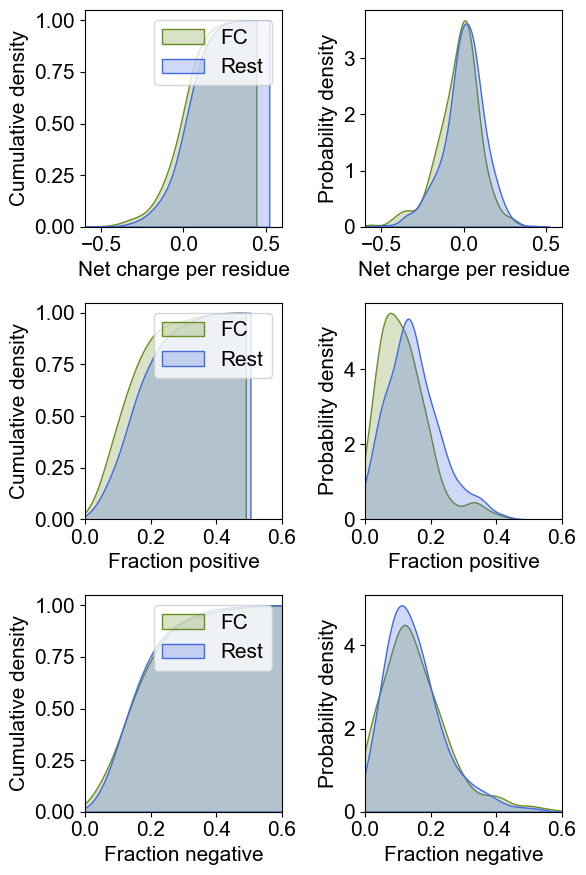

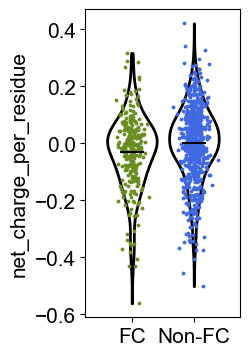

Welch t-test for data 0 and data 1:  Ttest_indResult(statistic=-3.491040973514217, pvalue=0.0005257806226472095)


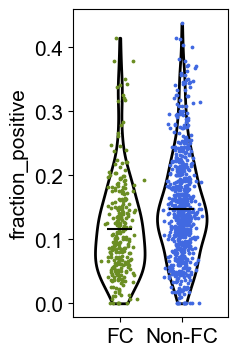

Welch t-test for data 0 and data 1:  Ttest_indResult(statistic=-5.647535237124551, pvalue=2.6700980400866305e-08)


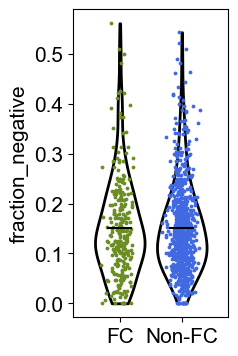

Welch t-test for data 0 and data 1:  Ttest_indResult(statistic=0.1256935271204168, pvalue=0.9000300776034348)


In [43]:
# Charge features of IDRs from Human Cell Atlas 

charge_features_dict_list = analyze_files(fasta_file_list=
                                          ['Human_Protein_Atlas/HPA_human_FC_proteins.fasta',
                                           'Human_Protein_Atlas/HPA_human_nonFC_proteins.fasta'],
                                          iprscan_file_list=
                                          ['Human_Protein_Atlas/HPA_human_FC.tsv', 
                                           'Human_Protein_Atlas/HPA_human_nonFC.tsv'],
                                          names=['FC', 'Rest'], colors= ['olivedrab', 'royalblue'],
                                          figname='Human')

keys = ['net_charge_per_residue', 'fraction_positive', 
            'fraction_negative']

for key in keys:
    make_violin_plots(dataset=[charge_features_dict_list[0][key], charge_features_dict_list[1][key]],
                      labels=['FC', 'Non-FC'],
                      colors=['olivedrab', 'royalblue'],
                      ylabel=key,
                      figname='Figures_for_paper/Charge_distribution' + key)

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


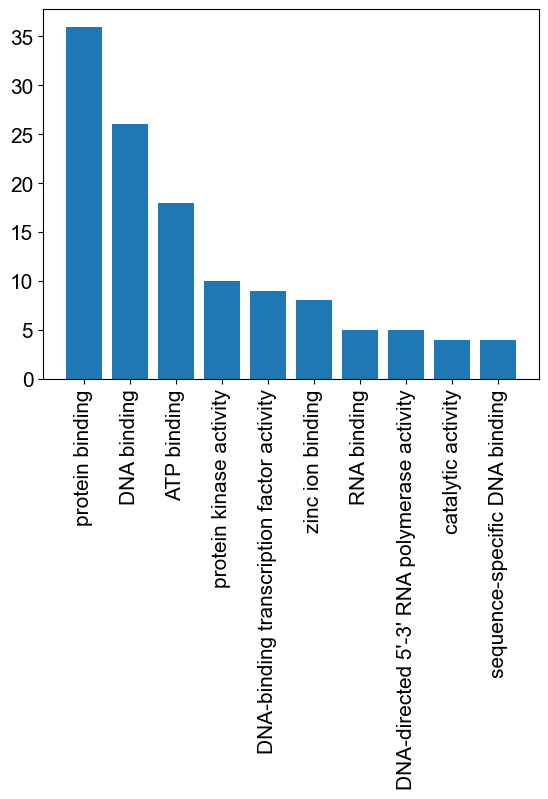

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


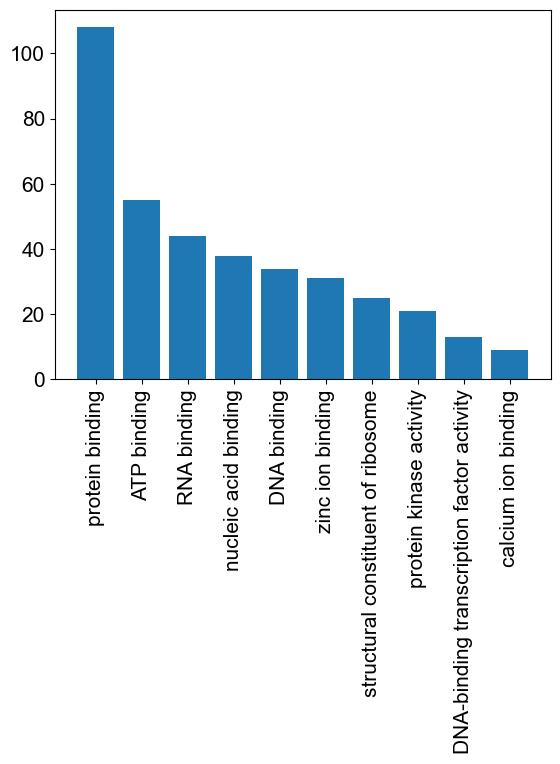

          go_id                                    go_name  \
32   GO:0003677                                DNA binding   
31   GO:0003676                       nucleic acid binding   
39   GO:0003723                                RNA binding   
36   GO:0003700  DNA-binding transcription factor activity   
43   GO:0003735         structural constituent of ribosome   
102  GO:0005515                            protein binding   
76   GO:0004672                    protein kinase activity   
104  GO:0005524                                ATP binding   
225  GO:0008270                           zinc ion binding   
355  GO:0043565              sequence-specific DNA binding   

           go_namespace    FC   Rest    pvalue  fraction_FC  fraction_Rest  \
32   molecular_function  26.0   34.0  0.000146     0.088737       0.034102   
31   molecular_function   2.0   38.0  0.002025     0.006826       0.038114   
39   molecular_function   5.0   44.0  0.012771     0.017065       0.044132   
36   

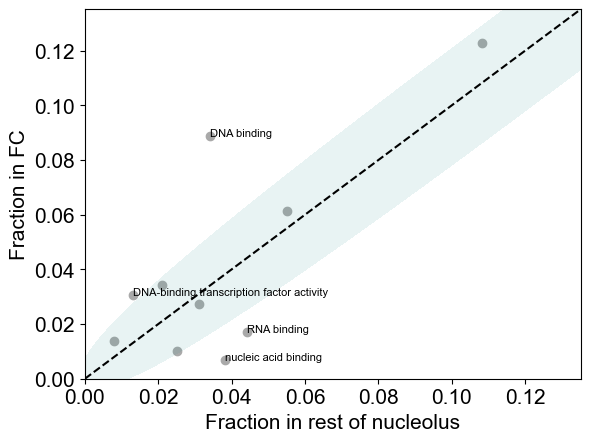

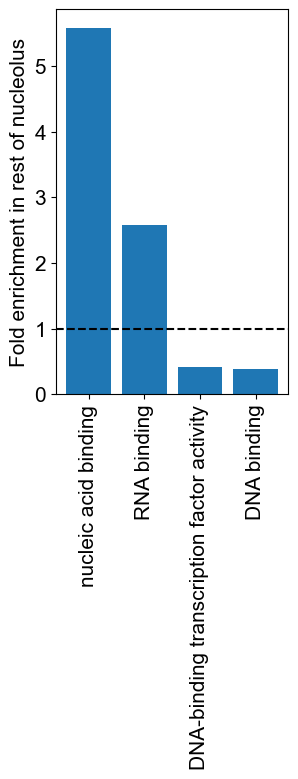

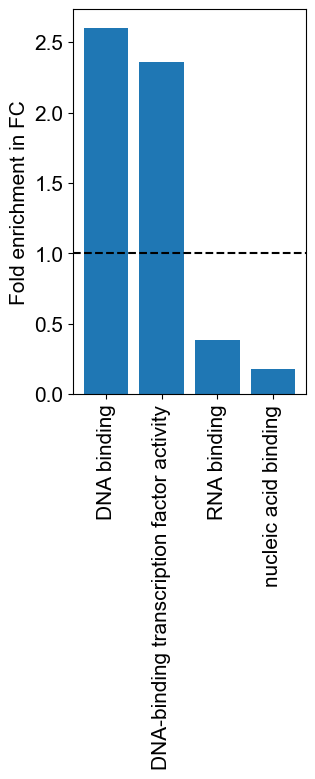

In [44]:
analyze_structured_domains(fasta_file_list=
                           ['Human_Protein_Atlas/HPA_human_FC_proteins.fasta',
                            'Human_Protein_Atlas/HPA_human_nonFC_proteins.fasta'],
                           iprscan_file_list=
                           ['Human_Protein_Atlas/HPA_human_FC.tsv', 
                            'Human_Protein_Atlas/HPA_human_nonFC.tsv'],
                          figname='Human')

# Mouse: FC vs rest of the nucleolus

## Analysis of IDRs

Number of IDRs from Uniprot_GO_annotations_consolidated/FC_proteins_mouse.tsv :  154


Number of IDRs from Uniprot_GO_annotations_consolidated/Nucleolar_proteins_mouse.tsv :  599
Average  Net charge per residue in FC : -0.01198539346479151
Average  Fraction positive in FC : 0.13554470762071805
Average  Fraction negative in FC : 0.1509103951113525
Average  Net charge per residue in Rest : -0.002007758028547703
Average  Fraction positive in Rest : 0.15551606760003903
Average  Fraction negative in Rest : 0.1601835216861065


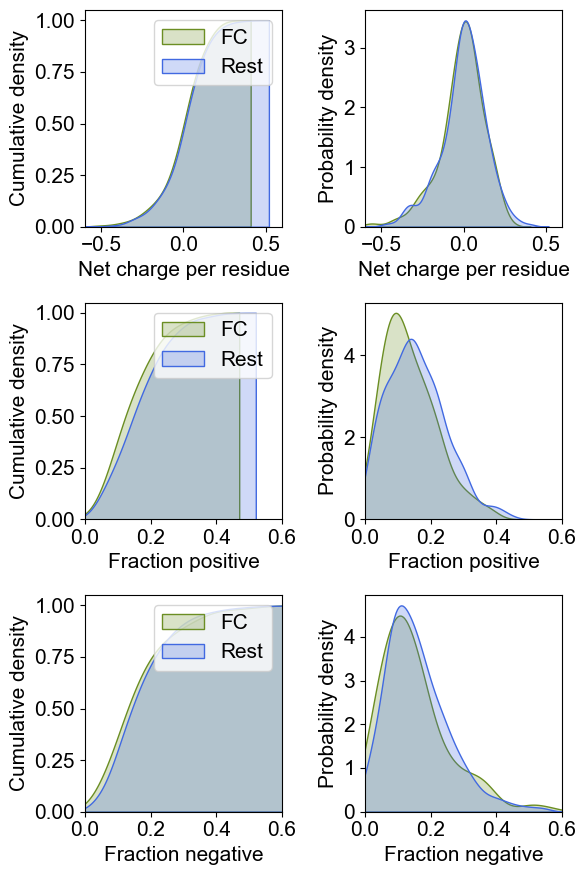

net_charge_per_residue :  KstestResult(statistic=0.06395941287427097, pvalue=0.6690443205781824)
fraction_positive :  KstestResult(statistic=0.14738850465060815, pvalue=0.008597938713902464)
fraction_negative :  KstestResult(statistic=0.08450230904321054, pvalue=0.324248666530663)


In [11]:
charge_features_dict_list = analyze_files(fasta_file_list=
                                          ['Uniprot_GO_annotations_consolidated/FC_proteins_mouse.fasta',
                                           'Uniprot_GO_annotations_consolidated/Nucleolar_proteins_mouse.fasta'],
                                          iprscan_file_list=
                                          ['Uniprot_GO_annotations_consolidated/FC_proteins_mouse.tsv', 
                                           'Uniprot_GO_annotations_consolidated/Nucleolar_proteins_mouse.tsv'],
                                          names=['FC', 'Rest'], colors= ['olivedrab', 'royalblue'],
                                          figname='Mouse')

keys = ['net_charge_per_residue', 'fraction_positive', 'fraction_negative']

for key in keys:
    results = ks_2samp(charge_features_dict_list[0][key], charge_features_dict_list[1][key])
    print(key, ': ', results)

## Analysis of structured domains

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


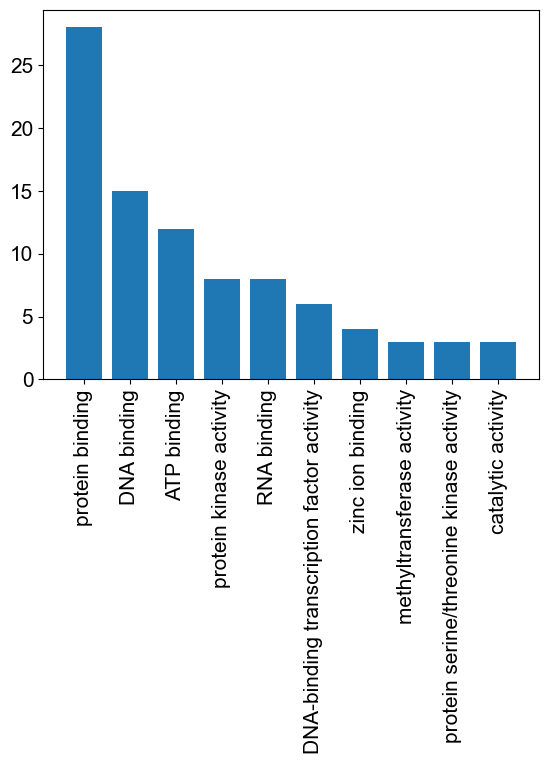

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


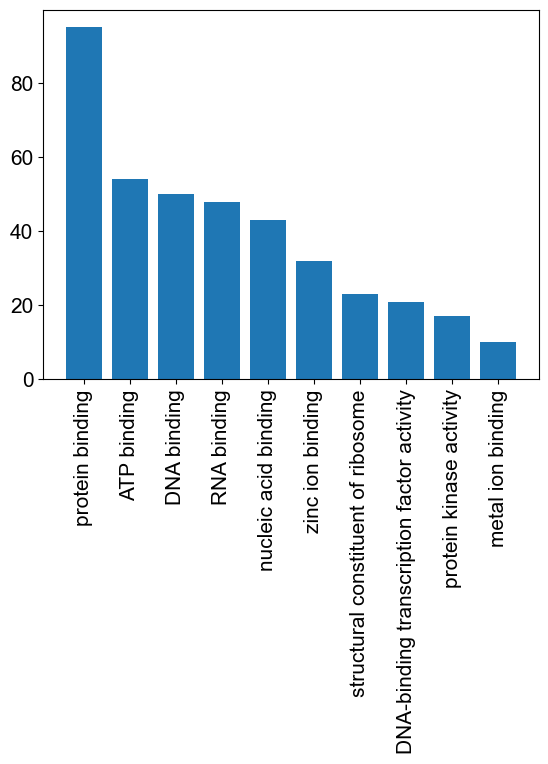

          go_id                                    go_name  \
40   GO:0003676                       nucleic acid binding   
106  GO:0005515                            protein binding   
81   GO:0004672                    protein kinase activity   
50   GO:0003735         structural constituent of ribosome   
41   GO:0003677                                DNA binding   
214  GO:0008270                           zinc ion binding   
107  GO:0005524                                ATP binding   
46   GO:0003723                                RNA binding   
44   GO:0003700  DNA-binding transcription factor activity   
47   GO:0003724                      RNA helicase activity   
329  GO:0046872                          metal ion binding   
331  GO:0046983              protein dimerization activity   

           go_namespace    FC  Rest    pvalue  enrichment  
40   molecular_function   2.0  43.0  0.007705    4.463983  
106  molecular_function  28.0  95.0  0.021702    0.704449  
81   molecula

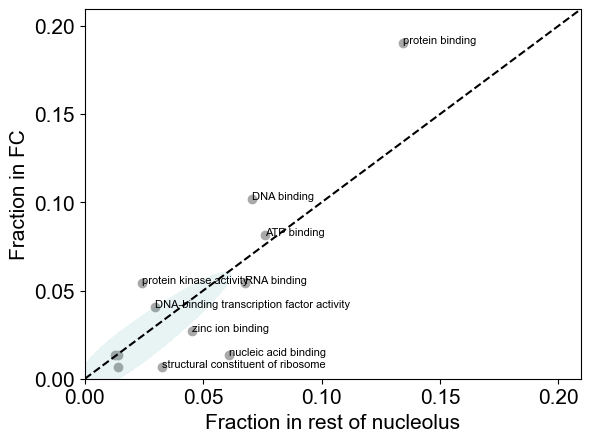

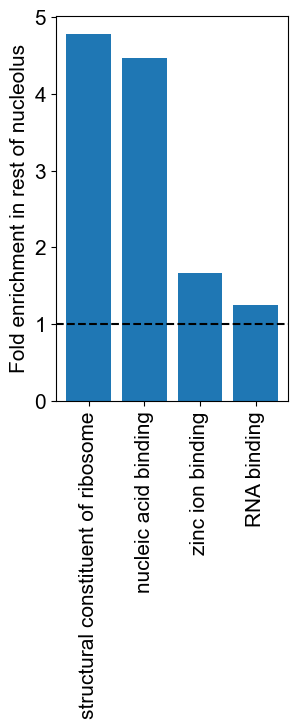

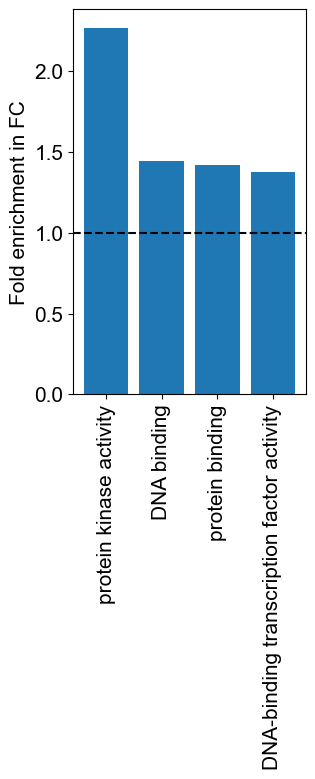

In [346]:
analyze_structured_domains(fasta_file_list=['Uniprot_GO_annotations_consolidated/FC_proteins_mouse.fasta', 
                                            'Uniprot_GO_annotations_consolidated/Nucleolar_proteins_mouse.fasta'],
                           iprscan_file_list=
                           ['Uniprot_GO_annotations_consolidated/FC_proteins_mouse.tsv', 
                            'Uniprot_GO_annotations_consolidated/Nucleolar_proteins_mouse.tsv'],
                           figname='Mouse')

# Using Mouse proteins from HPA

### IDRS

Number of IDRs from Human_Protein_Atlas/HPA_mouse_FC.tsv :  246
Number of IDRs from Human_Protein_Atlas/HPA_mouse_nonFC.tsv :  603
Average  Net charge per residue in FC : -0.025674462023513228
Average  Fraction positive in FC : 0.11953125794464953
Average  Fraction negative in FC : 0.1491296710281904
Average  Net charge per residue in Rest : -0.005815106613331634
Average  Fraction positive in Rest : 0.14550798733769899
Average  Fraction negative in Rest : 0.15426025015907546


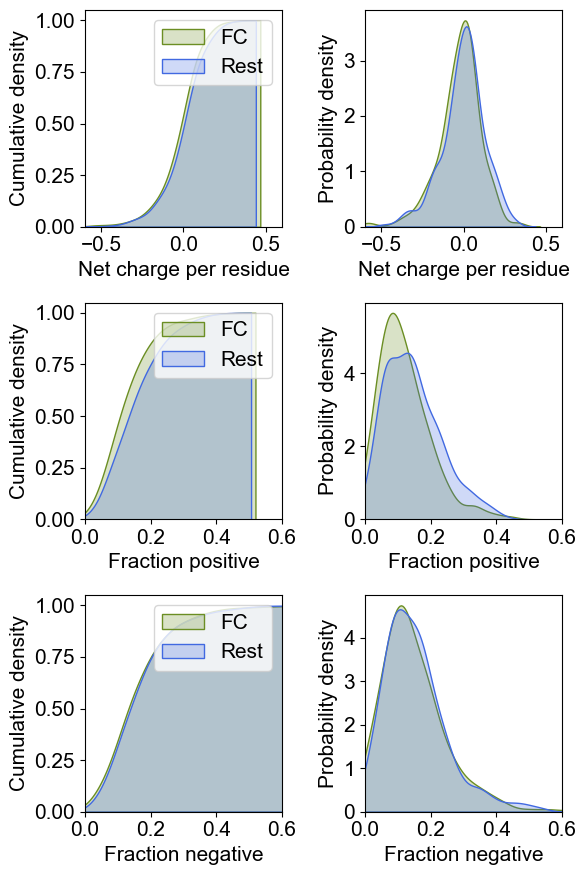

net_charge_per_residue :  Ttest_indResult(statistic=-1.9700593708206577, pvalue=0.04915697313507759)
fraction_positive :  Ttest_indResult(statistic=-4.099528196259354, pvalue=4.5384487843146316e-05)
fraction_negative :  Ttest_indResult(statistic=-0.6846249031777832, pvalue=0.4937679365989003)


In [13]:
# Charge features of IDRs from Human Cell Atlas 

charge_features_dict_list = analyze_files(fasta_file_list=
                                          ['Human_Protein_Atlas/HPA_mouse_FC_proteins.fasta',
                                           'Human_Protein_Atlas/HPA_mouse_nonFC_proteins.fasta'],
                                          iprscan_file_list=
                                          ['Human_Protein_Atlas/HPA_mouse_FC.tsv', 
                                           'Human_Protein_Atlas/HPA_mouse_nonFC.tsv'],
                                          names=['FC', 'Rest'], colors= ['olivedrab', 'royalblue'],
                                          figname='Mouse')

keys = ['net_charge_per_residue', 'fraction_positive', 
            'fraction_negative']

for key in keys:
    results = ttest_ind(charge_features_dict_list[0][key], charge_features_dict_list[1][key])
    print(key, ': ', results)

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


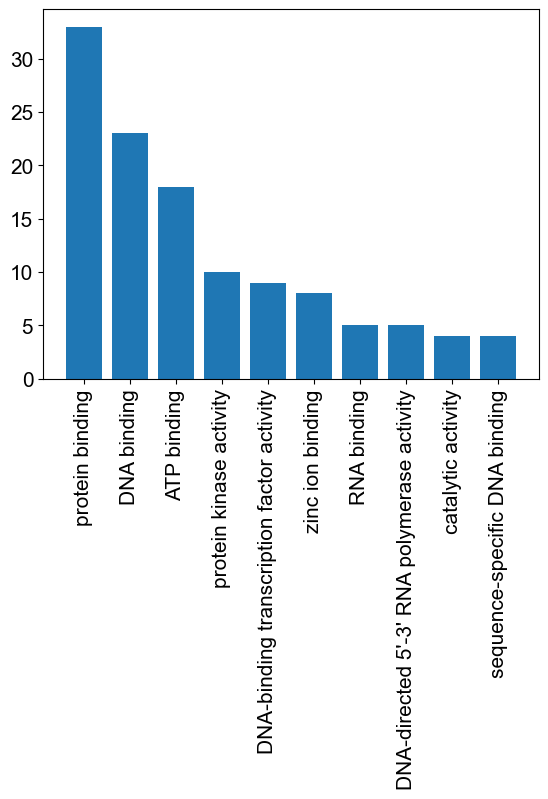

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


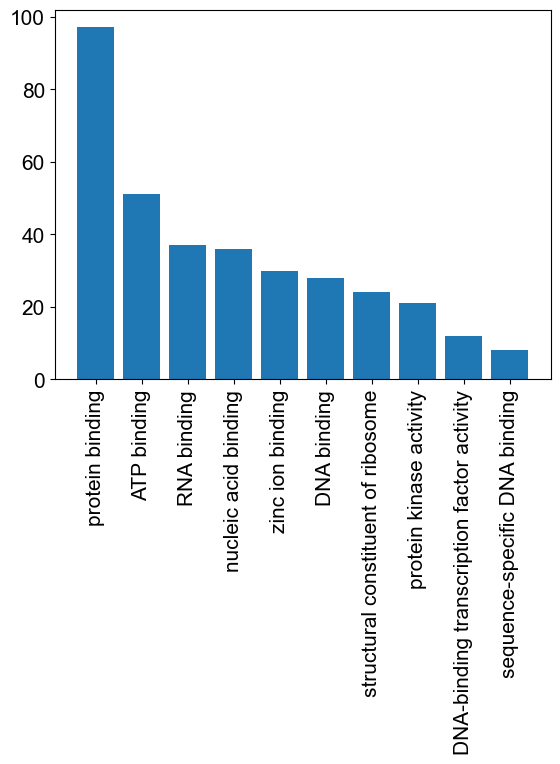

          go_id                                    go_name  \
29   GO:0003677                                DNA binding   
28   GO:0003676                       nucleic acid binding   
33   GO:0003700  DNA-binding transcription factor activity   
36   GO:0003723                                RNA binding   
40   GO:0003735         structural constituent of ribosome   
99   GO:0005515                            protein binding   
73   GO:0004672                    protein kinase activity   
101  GO:0005524                                ATP binding   
219  GO:0008270                           zinc ion binding   
346  GO:0043565              sequence-specific DNA binding   

           go_namespace    FC  Rest    pvalue  enrichment  
29   molecular_function  23.0  28.0  0.000207    0.364636  
28   molecular_function   2.0  36.0  0.002671    5.391408  
33   molecular_function   9.0  12.0  0.022572    0.399364  
36   molecular_function   5.0  37.0  0.032592    2.216468  
40   molecular_fu

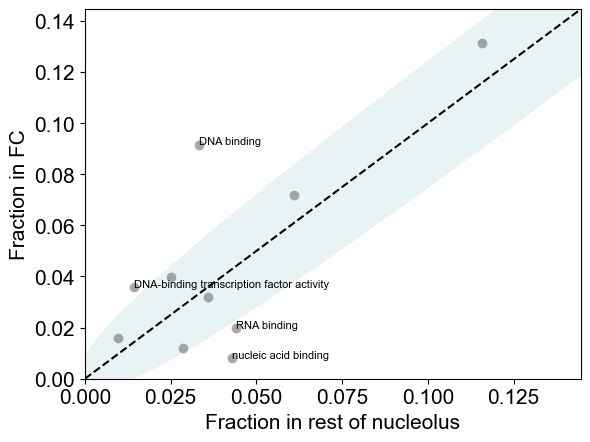

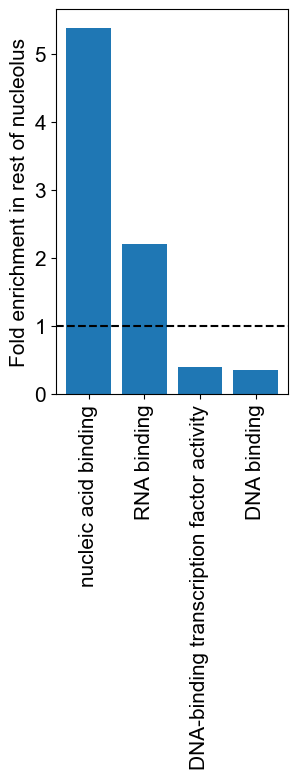

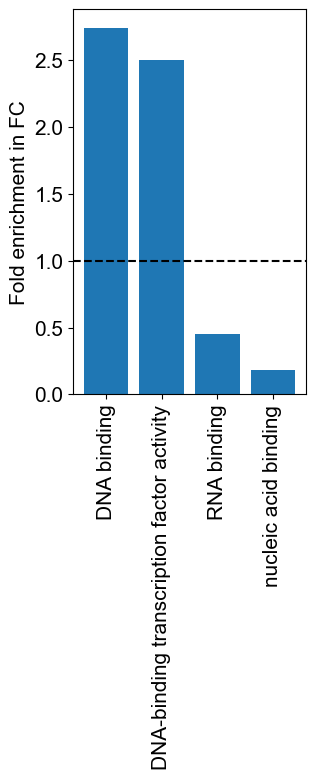

In [19]:
analyze_structured_domains(fasta_file_list=
                           ['Human_Protein_Atlas/HPA_mouse_FC_proteins.fasta',
                            'Human_Protein_Atlas/HPA_mouse_nonFC_proteins.fasta'],
                           iprscan_file_list=
                           ['Human_Protein_Atlas/HPA_mouse_FC.tsv', 
                            'Human_Protein_Atlas/HPA_mouse_nonFC.tsv'],
                           figname='Mouse')

# All proteins including unreviewed, using the NOT FC condition

In [ ]:
charge_features_dict_list = analyze_files(fasta_file_list=
                                          ['Uniprot_Human/FC_proteins_human_2.fasta',
                                           'Uniprot_Human/Nucleolar_proteins_human_2.fasta'],
                                          iprscan_file_list=
                                          ['Uniprot_Human/FC_proteins_human_2.tsv', 
                                           'Uniprot_Human/Nucleolar_proteins_human_2.tsv'],
                                          names=['FC', 'Rest'])

keys = ['net_charge_per_residue', 'fraction_positive', 
            'fraction_negative']

for key in keys:
    results = ks_2samp(charge_features_dict_list[0][key], charge_features_dict_list[1][key])
    print(key, ': ', results)

analyze_structured_domains(fasta_file_list=['Uniprot_Human/FC_proteins_human_2.fasta',
                                           'Uniprot_Human/Nucleolar_proteins_human_2.fasta'],
                           iprscan_file_list=['Uniprot_Human/FC_proteins_human_2.tsv',
                                           'Uniprot_Human/Nucleolar_proteins_human_2.tsv'])

charge_features_dict_list = analyze_files(fasta_file_list=
                                          ['Uniprot_Mouse/FC_proteins_mouse.fasta',
                                           'Uniprot_Mouse/Nucleolar_proteins_mouse.fasta'],
                                          iprscan_file_list=
                                          ['Uniprot_Mouse/FC_proteins_mouse_additional_databases.tsv', 
                                           'Uniprot_Mouse/Nucleolar_proteins_mouse_additional_databases.tsv'],
                                          names=['FC', 'Rest'])

keys = ['net_charge_per_residue', 'fraction_positive', 'fraction_negative']

for key in keys:
    results = ks_2samp(charge_features_dict_list[0][key], charge_features_dict_list[1][key])
    print(key, ': ', results)
    
analyze_structured_domains(fasta_file_list=['Uniprot_Mouse/FC_proteins_mouse.fasta', 
                            'Uniprot_Mouse/Nucleolar_proteins_mouse.fasta'],
                           iprscan_file_list=
                           ['Uniprot_Mouse/FC_proteins_mouse_additional_databases.tsv', 
                            'Uniprot_Mouse/Nucleolar_proteins_mouse_additional_databases.tsv'])

# Only reviewed proteins, but without using the NOT FC condition

In [ ]:
charge_features_dict_list = analyze_files(fasta_file_list=
                                          ['Uniprot_Human/FC_proteins_human.fasta',
                                           'Uniprot_Human/Nucleolar_proteins_human.fasta'],
                                          iprscan_file_list=
                                          ['Uniprot_Human/FC_proteins_human_additional_databases.tsv', 
                                           'Uniprot_Human/Nucleolar_proteins_human_additional_databases.tsv'],
                                          names=['FC', 'Rest'])

keys = ['net_charge_per_residue', 'fraction_positive', 
            'fraction_negative']

for key in keys:
    results = ks_2samp(charge_features_dict_list[0][key], charge_features_dict_list[1][key])
    print(key, ': ', results)
    
analyze_structured_domains(fasta_file_list=['Uniprot_Human/FC_proteins_human.fasta',
                                           'Uniprot_Human/Nucleolar_proteins_human.fasta'],
                           iprscan_file_list=['Uniprot_Human/FC_proteins_human_additional_databases.tsv',
                                           'Uniprot_Human/Nucleolar_proteins_human_additional_databases.tsv'])
    

charge_features_dict_list = analyze_files(fasta_file_list=
                                          ['Uniprot_Mouse/FC_proteins_mouse_2.fasta',
                                           'Uniprot_Mouse/Nucleolar_proteins_mouse_2.fasta'],
                                          iprscan_file_list=
                                          ['Uniprot_Mouse/FC_proteins_mouse_2.tsv', 
                                           'Uniprot_Mouse/Nucleolar_proteins_mouse_2.tsv'],
                                          names=['FC', 'Rest'])

keys = ['net_charge_per_residue', 'fraction_positive', 'fraction_negative']

for key in keys:
    results = ks_2samp(charge_features_dict_list[0][key], charge_features_dict_list[1][key])
    print(key, ': ', results)
    
analyze_structured_domains(fasta_file_list=
                                          ['Uniprot_Mouse/FC_proteins_mouse_2.fasta',
                                           'Uniprot_Mouse/Nucleolar_proteins_mouse_2.fasta'],
                                          iprscan_file_list=
                                          ['Uniprot_Mouse/FC_proteins_mouse_2.tsv', 
                                           'Uniprot_Mouse/Nucleolar_proteins_mouse_2.tsv'])